In [1]:
# 1) Uninstall any old copies
%pip uninstall -y numpy pandas torch torchvision torchaudio

# 2) Reinstall NumPy and pandas (you can add --force-reinstall if you really want to rebuild)
%pip install --upgrade numpy==1.23.5 pandas==1.5.3

# 3) Install CPU‑only PyTorch (and related packages) from the official PyTorch wheel index
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Found existing installation: numpy 2.1.2
Uninstalling numpy-2.1.2:
  Successfully uninstalled numpy-2.1.2
Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Successfully uninstalled pandas-1.5.3
Found existing installation: torch 2.5.1+cpu
Uninstalling torch-2.5.1+cpu:
  Successfully uninstalled torch-2.5.1+cpu
Found existing installation: torchvision 0.20.1+cpu
Uninstalling torchvision-0.20.1+cpu:
  Successfully uninstalled torchvision-0.20.1+cpu
Found existing installation: torchaudio 2.5.1+cpu
Uninstalling torchaudio-2.5.1+cpu:
  Successfully uninstalled torchaudio-2.5.1+cpu
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
  Obtaining 

In [2]:
import sys

In [3]:
import torch

In [4]:
sys.path.append("./minGPT")

In [5]:
import sys, os, re, torch, pickle
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from mingpt.utils import set_seed  # Ensure minGPT is installed as editable
set_seed(3407)

In [6]:
from mingpt.model import GPT
from mingpt.trainer import Trainer

In [7]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install regex

  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
from mingpt.bpe import get_encoder

In [10]:
demographic_path = "./DAIC demographic data.xlsx"
demographic_df = pd.read_excel(demographic_path, sheet_name="Metadata_mapping")
print("Demographic data shape:", demographic_df.shape)
demographic_df.head()

Demographic data shape: (219, 2)


,Participant_ID,PHQ_Score
0,300,2
1,301,3
2,302,4
3,303,0
4,304,6


In [11]:
demographic_df["Participant_ID"] = demographic_df["Participant_ID"].astype(int)
phq8_dict = demographic_df.set_index("Participant_ID")["PHQ_Score"].to_dict()

In [12]:
print("Sample mapping (participant_id: PHQ8):")
for pid, score in list(phq8_dict.items())[:5]:
    print(pid, score)

Sample mapping (participant_id: PHQ8):
300 2
301 3
302 4
303 0
304 6


In [13]:
interviewdata_df  = pd.read_excel(demographic_path, sheet_name="Interview_Data", header=0)
interviewdata_df.columns = interviewdata_df.columns.str.strip()
mask = interviewdata_df["Partic#"]!="Participant Number"
interviewdata_df = interviewdata_df[mask]
interviewdata_df["Partic#"] = pd.to_numeric(interviewdata_df["Partic#"], errors="coerce")
interviewdata_df = interviewdata_df.dropna(subset=["Partic#"])
interviewdata_df["Partic#"] = interviewdata_df["Partic#"].astype(int)

gender_mapping = {
    1: "Male",
    2: "Female"
}

race_mapping = {
    1: "African American",
    2: "Asian",
    3: "White/Caucasian",
    4: "Hispanic",
    5: "Native American",
    6: "Native Hawaiian/Other Pacific Islander",
    7: "Other"
}

demographic_info = {}
for _, row in interviewdata_df.iterrows():
    pid = int(row["Partic#"])
    try:
        gender_code = int(row["gender"])
        race_code = int(row["race"])
    except Exception:
        continue
    demographic_info[pid] = {
        "gender": gender_mapping.get(gender_code, "Unknown"),
        "race": race_mapping.get(race_code, "Unknown"),
    }

In [14]:
transcript_path = "./E-DAIC_Transcripts"
transcript_files = [f for f in os.listdir(transcript_path) if f.endswith(".csv")]
print("Found {} transcript files.".format(len(transcript_files)))

Found 190 transcript files.


In [15]:
import io
import csv

In [16]:
examples = []

for filename in transcript_files:
    file_path = os.path.join(transcript_path, filename)
    
    # Extract participant_id from filename (files are named like "657_Transcript.csv")
    try:
        participant_id = int(filename.split("_")[0].strip())
    except Exception as e:
        print(f"Error extracting participant id from {filename}: {e}. Skipping.")
        continue

    # Check if the participant is in the mapping
    if participant_id not in phq8_dict:
        print(f"Participant {filename} (extracted id: {participant_id}) not found in PHQ8 mapping. Skipping.")
        continue
    if participant_id not in demographic_info:
        continue


    # Read the CSV file by reading all text, stripping trailing whitespace, then using StringIO
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            file_contents = f.read().rstrip()  # remove trailing whitespace/newlines
        transcript_df = pd.read_csv(
            io.StringIO(file_contents),
            engine='python',
            on_bad_lines='skip',  # Skip problematic lines
            quoting=csv.QUOTE_NONE      # Avoid issues with quotes
        )
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Check if the expected column exists. Here we assume the column name is "Text"
    if "Text" not in transcript_df.columns:
        print(f"Warning: The file {filename} does not have a 'Text' column. Skipping this file.")
        continue

    # Concatenate all rows from the "Text" column into one string (preserving internal spaces)
    transcript_text = " ".join(transcript_df["Text"].astype(str).tolist())
    
    # Get the corresponding PHQ8 score from the mapping
    phq8 = phq8_dict[participant_id]
    demographic = demographic_info[participant_id]
    
    # Append a dictionary with the participant id, transcript, and PHQ8 score
    examples.append({
        "participant_id": participant_id,
        "transcript": transcript_text,
        "PHQ8": phq8,
        "gender": demographic["gender"],
        "race": demographic["race"]
    })

print("Processed {} files successfully.".format(len(examples)))

# Optionally, display a few examples for inspection:
for ex in examples[:3]:
    print(ex)

Participant 718_Transcript.csv (extracted id: 718) not found in PHQ8 mapping. Skipping.
Participant 651_Transcript.csv (extracted id: 651) not found in PHQ8 mapping. Skipping.
Participant 664_Transcript.csv (extracted id: 664) not found in PHQ8 mapping. Skipping.
Participant 669_Transcript.csv (extracted id: 669) not found in PHQ8 mapping. Skipping.
Participant 600_Transcript.csv (extracted id: 600) not found in PHQ8 mapping. Skipping.
Participant 693_Transcript.csv (extracted id: 693) not found in PHQ8 mapping. Skipping.
Participant 716_Transcript.csv (extracted id: 716) not found in PHQ8 mapping. Skipping.
Participant 715_Transcript.csv (extracted id: 715) not found in PHQ8 mapping. Skipping.
Participant 623_Transcript.csv (extracted id: 623) not found in PHQ8 mapping. Skipping.
Participant 631_Transcript.csv (extracted id: 631) not found in PHQ8 mapping. Skipping.
Participant 619_Transcript.csv (extracted id: 619) not found in PHQ8 mapping. Skipping.
Participant 652_Transcript.csv (

In [17]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from mingpt.bpe import get_encoder
from mingpt.model import GPT
from mingpt.trainer import Trainer
from scipy.stats import pearsonr
import re

In [18]:
#Building dataset
class TranscriptDataset(Dataset):
    def __init__(self, examples, encoder, block_size=256):
        self.examples   = examples
        self.encoder    = encoder
        self.block_size = block_size
        self.pad_id     = 0
        self.template   = (
            'Given the following transcript, find the PHQ‑8 score.\n\n'
            'Transcript: "{}"\n\n'
            'Answer: {}'
        )
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, idx):
        ex = self.examples[idx]
        txt = self.template.format(ex["transcript"], ex["PHQ8"])
        tokens = self.encoder.encode(txt)
        maxlen = self.block_size + 1
        if len(tokens) > maxlen:
            tokens = tokens[:maxlen]
        else:
            tokens += [self.pad_id] * (maxlen - len(tokens))
        t = torch.tensor(tokens, dtype=torch.long)
        x = t[:-1]               # input
        y = t[1:].clone()        # target
        y[x == self.pad_id] = -1 # mask pad tokens in loss
        return x, y

# 2) BUILD DATASET & DATALOADERS
encoder = get_encoder()
dataset = TranscriptDataset(examples, encoder, block_size=128)

n = len(dataset)
train_n = int(0.8 * n)
test_n  = n - train_n
train_ds, test_ds = random_split(
    dataset,
    [train_n, test_n],
    generator=torch.Generator().manual_seed(3407)
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0)

# 3) INSTANTIATE GPT‑NANO
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size  = len(encoder.encoder)  # your BPE vocab size
model_config.block_size  = 256                  # must match dataset
model = GPT(model_config)
print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.3f}M")



number of parameters: 2.51M
Model params: 4.922M


In [19]:
# 4) TRAINER SETUP
from mingpt.trainer import Trainer
train_cfg = Trainer.get_default_config()
train_cfg.learning_rate = 5e-4
train_cfg.max_iters     = 2000
train_cfg.batch_size    = 8
train_cfg.num_workers   = 0

trainer = Trainer(train_cfg, model, train_ds)
trainer.set_callback('on_batch_end',
    lambda t: print(f"iter {t.iter_num}: loss {t.loss.item():.4f}")
                if t.iter_num % 200 == 0 else None
)
print("Training on:", trainer.device)
trainer.run()

running on device cpu
Training on: cpu
iter 0: loss 10.8289
iter 200: loss 4.9431
iter 400: loss 3.4353
iter 600: loss 2.7148
iter 800: loss 2.5018
iter 1000: loss 2.1006
iter 1200: loss 1.7549
iter 1400: loss 1.5056
iter 1600: loss 1.3848
iter 1800: loss 1.2302


In [40]:
import random, re, torch

def make_few_shot_header(exs, k=5):
    shots = random.sample(exs, k)
    header = ""
    for s in shots:
        header += (
          "Given the following transcript, find the PHQ‑8 score.\n\n"
          f'Transcript: "{s["transcript"]}"\n\n'
          f"Answer: {s['PHQ8']}\n\n"
        )
    return header

def generate_with_sampling(transcript, max_new_tokens=20, k=3):
    header = make_few_shot_header(examples, k)
    prompt = header + (
        "Given the following transcript, find the PHQ‑8 score.\n\n"
        f'Transcript: "{transcript}"\n\n'
        "Answer:"
    )
    ctx = torch.tensor(encoder.encode(prompt), dtype=torch.long
                     ).unsqueeze(0).to(trainer.device)
    out = model.generate(
        ctx,
        max_new_tokens=max_new_tokens,
        temperature=0.8,
        do_sample=True,     
        top_k=50      
    )
    txt = encoder.decode(out[0].tolist())
    # match the number after "Answer:"
    m = re.search(r'Answer:\s*(\d+)', txt)
    if m:
        return int(m.group(1))
    # fallback to any 1–2 digit number
    nums = re.findall(r'\b(\d{1,2})\b', txt)
    return int(nums[0]) if nums else None

records = []
for idx in test_ds.indices:
    ex   = examples[idx]
    pred = generate_with_sampling(ex["transcript"], max_new_tokens=20, k=5)
    if pred is None:
        continue
    records.append({
        "participant_id": ex["participant_id"],
        "actual":         ex["PHQ8"],
        "predicted":      pred,
        "gender":         ex["gender"],
        "race":           ex["race"]
    })

df = pd.DataFrame(records)

In [41]:
# 4) COMPUTE PEARSON’S r AND AVERAGE RELATIVE ERROR
import numpy as np
from scipy.stats import pearsonr

MAX_PHQ8 = 24.0

def pearson_r(subdf):
    if len(subdf) < 2:
        return np.nan
    return pearsonr(subdf["actual"], subdf["predicted"])[0]

def avg_re(subdf):
    return np.mean(np.abs(subdf["predicted"] - subdf["actual"]) / MAX_PHQ8)

# Overall
r_all  = pearson_r(df)
re_all = avg_re(df)
print(f"Overall Pearson r: {r_all:.3f}, Avg RE: {re_all:.3f}\n")

# By gender
print("By Gender:")
for gender, group in df.groupby("gender"):
    if len(group) < 2:
        print(f"  {gender}: insufficient data")
        continue
    print(f"  {gender}: r={pearson_r(group):.3f}, RE={avg_re(group):.3f}")
print()

# By race
print("By Race:")
for race, group in df.groupby("race"):
    if len(group) < 2:
        print(f"  {race}: insufficient data")
        continue
    print(f"  {race}: r={pearson_r(group):.3f}, RE={avg_re(group):.3f}")
print()

# By gender × race
print("By Gender and Race:")
for (g, r), group in df.groupby(["gender","race"]):
    if len(group) < 2:
        print(f"  {g}/{r}: insufficient data")
        continue
    print(f"  {g}/{r}: r={pearson_r(group):.3f}, RE={avg_re(group):.3f}")


Overall → Pearson r: 0.239, Avg RE: 0.285

By Gender:
  Female: r=0.713, RE=0.213
  Male: r=0.010, RE=0.322

By Race:
  African American: r=0.661, RE=0.137
  Asian: insufficient data
  Hispanic: r=0.221, RE=0.367
  Native American: r=-1.000, RE=0.229
  Other: r=1.000, RE=0.417
  White/Caucasian: r=-0.172, RE=0.405

By Gender × Race:
  Female/African American: r=0.576, RE=0.175
  Female/Hispanic: insufficient data
  Female/Native American: insufficient data
  Female/Other: insufficient data
  Female/White/Caucasian: insufficient data
  Male/African American: r=0.649, RE=0.100
  Male/Asian: insufficient data
  Male/Hispanic: r=-0.032, RE=0.323
  Male/Native American: insufficient data
  Male/Other: insufficient data
  Male/White/Caucasian: r=-0.323, RE=0.465


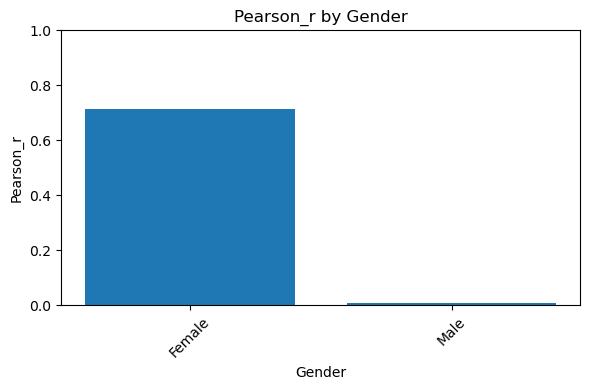

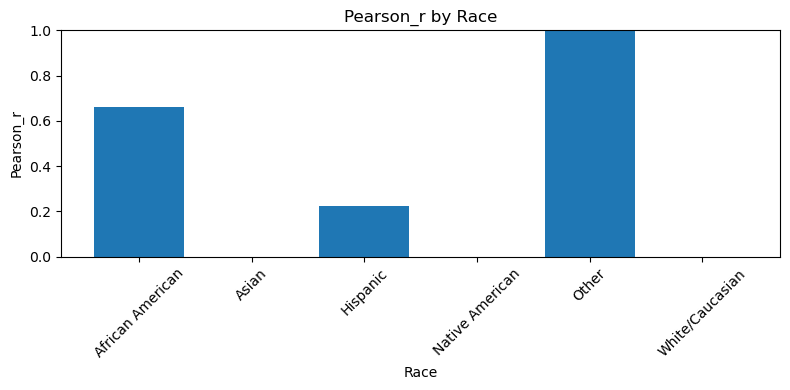

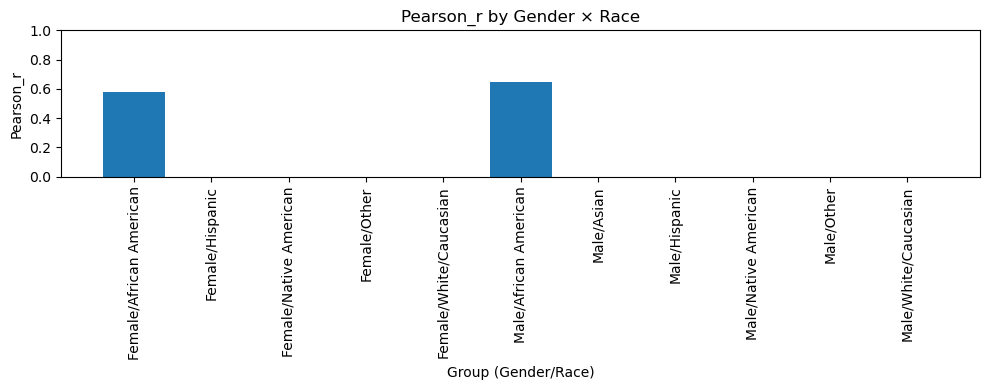

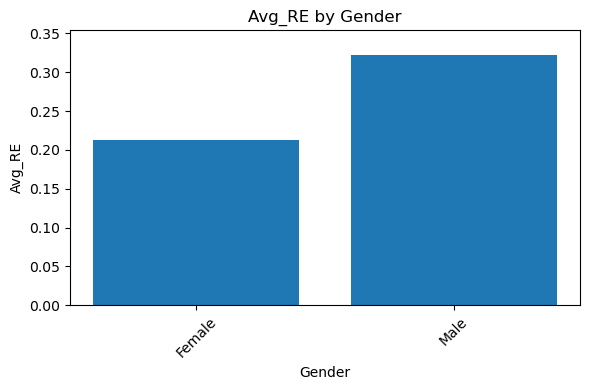

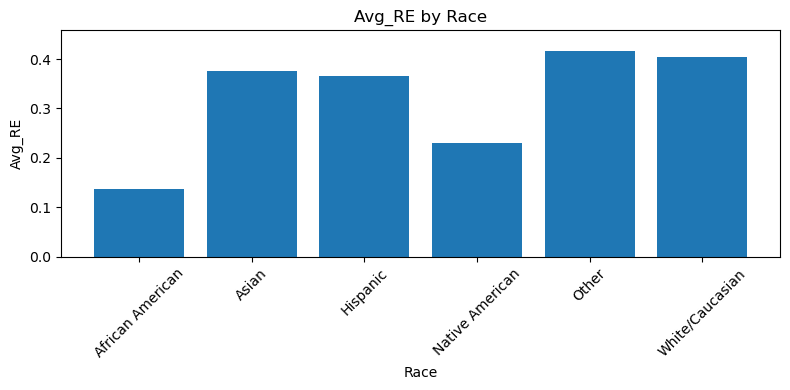

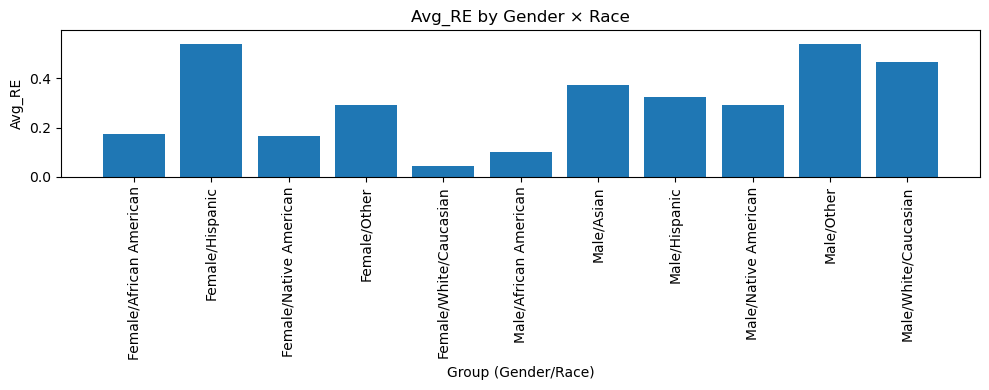

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# 1) Compute metrics by group
gender_metrics = (
    df.groupby("gender")
      .apply(lambda g: pd.Series({
          "Pearson_r": pearson_r(g),
          "Avg_RE":    avg_re(g)
      }))
)

race_metrics = (
    df.groupby("race")
      .apply(lambda g: pd.Series({
          "Pearson_r": pearson_r(g),
          "Avg_RE":    avg_re(g)
      }))
)

inter_metrics = (
    df.groupby(["gender", "race"])
      .apply(lambda g: pd.Series({
          "Pearson_r": pearson_r(g),
          "Avg_RE":    avg_re(g)
      }))
)
# Flatten multi-index for plotting
inter_metrics.index = [f"{g}/{r}" for g, r in inter_metrics.index]

# 2) Plotting
for metric in ["Pearson_r", "Avg_RE"]:
    # By Gender
    plt.figure(figsize=(6,4))
    plt.bar(gender_metrics.index, gender_metrics[metric])
    plt.title(f"{metric} by Gender")
    plt.xlabel("Gender")
    plt.ylabel(metric)
    plt.ylim(0, 1 if metric=="Pearson_r" else gender_metrics[metric].max()*1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # By Race
    plt.figure(figsize=(8,4))
    plt.bar(race_metrics.index, race_metrics[metric])
    plt.title(f"{metric} by Race")
    plt.xlabel("Race")
    plt.ylabel(metric)
    plt.ylim(0, 1 if metric=="Pearson_r" else race_metrics[metric].max()*1.1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # By Gender × Race
    plt.figure(figsize=(10,4))
    plt.bar(inter_metrics.index, inter_metrics[metric])
    plt.title(f"{metric} by Gender × Race")
    plt.xlabel("Group (Gender/Race)")
    plt.ylabel(metric)
    plt.ylim(0, 1 if metric=="Pearson_r" else inter_metrics[metric].max()*1.1)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()